# Reproducing Gunseli CDA Study (2019)
## Pipeline for all files

Note: No cleaning, no trial nor subject removal. All data is taken/used.
Note: They average differently in their study. They average all good contra trials over electrode and then substract contra - ipsi. I substract electrodes and then average over trials.  

- pp11 to be removed.
- pp24 causing trouble for cue = 5
- pp18 causing trouble for cue = 6

... to investigate vs Matlab .mat files

- I'm not using the behav files, I probably should!

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

import sys
#sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Gunseli-2019/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\Gunseli-2019\\')
from events import get_specific_events
 
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load, Prep & CDA

In [2]:
#==================================================================
# General Variables
#==================================================================
study_id = 'Gunseli2019'

triggers = dict();

triggers['80% valid'] = [5] 
triggers['50% valid'] = [6]

triggers['left'] = [10]
triggers['right'] = [20]
triggers['TBD'] = [30, 255]  # 255 is only for pp24 which doesn't have '30' but '255'

triggers['good'] = []
triggers['bad'] = []

# Labels
conds = ['80% valid', '50% valid']
sides = ['left', 'right', 'TBD']
perfs = ['good', 'bad']

# Internal Triggers to Epochs Properly
internal_triggers = dict()
internal_triggers_count = 0
for cond in conds:
    for side in sides:
        for perf in perfs:
            internal_triggers_count = internal_triggers_count + 1
            internal_triggers['{}-{}-{}'.format(cond,side,perf)] = internal_triggers_count
            
# CDA Channels
chan_right = ['P8', 'PO8', 'O2']
chan_left = ['P7', 'PO7', 'O1']

# Epoch Information
epoch_length = 1.2
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA info
cda_window = (0.4, 0.9)

# CDA main variable!
cda_dict_all = dict()
epochs_dict_all = dict()
perf_report_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/'
folderpath = 'D:\\CLNT\\Data\\Open Datasets\\Gunseli 2019\\'
sep = '\\'

#filepath = folderpath + 'raw data files/' + 'StratAtt_e2_LoadChans_pp11.set'
for filepath in glob.iglob(folderpath + 'raw data files' + sep + '*.set'):
    filename = filepath[filepath.rfind(sep)+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_eeglab(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Set Electrodes Locations - Used Brain Products (locations seem to in eeg file...)
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    preproc = raw.resample(500)

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = mne.events_from_annotations(preproc)

    # Select Channels (to save time on cleaning)
    #preproc = preproc.pick_channels(chan_right + chan_left)

    # Plot (visual check)
    #preproc.plot(events=events, block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    # Redo Triggers based on annotation in file!
    new_triggers = copy.deepcopy(triggers)
    for k in new_triggers.keys():
        for i,t in enumerate(new_triggers[k]):
            if str(t) in events[1].keys():
                new_triggers[k][i] = events[1][str(t)]
    specific_events = get_specific_events(events[0], conds, sides, perfs, new_triggers, internal_triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr, clean=True)

    epochs_dict_all[filename] = epochs_dict

    # times, used for CDA mean amp report.
    times = epochs_dict[conds[0]][sides[0]][perfs[0]].times

    # ------------------------
    # 4. -- CDA --
    # ------------------------
    cda_dict_all[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

    # ------------------------
    # 6. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report = add_cda_report(report, filename, conds, sides, perfs, cda_dict_all[filename], times, cda_window=cda_window)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

    perf_report_all[filename] = get_CDA_perf_report(epochs_dict, conds, sides, perfs, chan_right, chan_left, cda_window=cda_window)

# Print report
print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: StratAtt_e2_LoadChans_pp10.set...
Reading D:\CLNT\Data\Open Datasets\Gunseli 2019\raw data files\StratAtt_e2_LoadChans_pp10.fdt
Reading 0 ... 2025983  =      0.000 ...  3956.998 secs...


KeyboardInterrupt: 

## 2. Plot Grand CDA Average

Manual Skip...
Manual Skip...


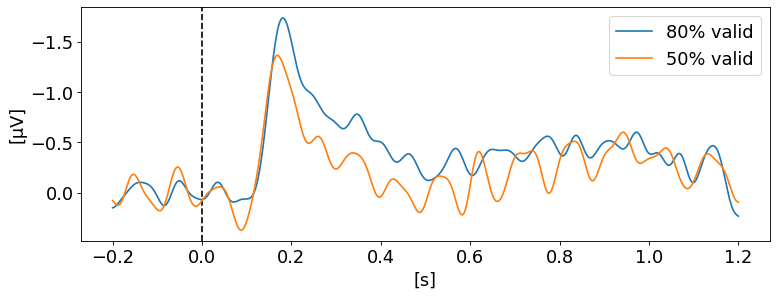

In [13]:
cda_all = dict()

# Get CDA GA
for cond in cda_dict_all[list(cda_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict_all.keys(): 
        ## ====== Manual Cleanup ========
        # TODO: Skip only 1 side.
        # TODO: Look at pp24 cue 6
        # TODO: Look at pp18 cue 5
        if (f == 'StratAtt_e2_LoadChans_pp11.set') or (f == 'StratAtt_e2_LoadChans_pp18.set' and cond == '5') or (f == 'StratAtt_e2_LoadChans_pp24.set' and cond == '6'):
        #if (f == 'StratAtt_e2_LoadChans_pp11.set'):# or (f == 'StratAtt_e2_LoadChans_pp18.set') or (f == 'StratAtt_e2_LoadChans_pp24.set'):
            print('Manual Skip...')
            continue
            
        perf = 'good'
        
        ldict = cda_dict_all[f][cond]['left']
        rdict = cda_dict_all[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict_all[f][cond]['left'][perf] + cda_dict_all[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Cond: {})".format(str(f), str(cond)))
            
# Plot
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(10, 4), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['80% valid'].mean(0) * 1e6, label='80% valid')
plt.plot(times, cda_all['50% valid'].mean(0) * 1e6, label='50% valid')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.gca().invert_yaxis()
plt.tight_layout()

fig.savefig("./{}-reprod.png".format(study_id), dpi=300, format='png')

## Matlab Preprocessed Files from Study (to compare)

In [3]:
import mat73
import numpy as np
import pandas as pd
import glob

import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline

#==================================================================
# General Variables
#==================================================================
triggers = dict();

triggers['5'] = [5] 
triggers['6'] = [6]

triggers['left'] = [10]
triggers['right'] = [20]
triggers['TBD'] = [30, 255]  # 255 is only for pp24 which doesn't have '30' but '255'

triggers['good'] = []
triggers['bad'] = []

# Labels
conds = ['5', '6']
sides = ['left', 'right', 'TBD']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['P8', 'PO8', 'O2']
chan_left = ['P7', 'PO7', 'O1']

cda_all_matlab = dict()
cda_all_matlab['5'] = np.array([])
cda_all_matlab['6'] = np.array([])

participants = [i for i in range(33) if i not in [0,1,20,27]]
participant = 4
#folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/'
folderpath = 'D:\\CLNT\\Data\\Open Datasets\\Gunseli 2019\\'

for participant in participants:
    filepath = folderpath + 'processed data files/{}_EEG_cueOnset.mat'.format(participant)
    
    # Keep only clean ones...
    mat_data = mat73.loadmat(filepath)
    idx_to_remove = mat_data['erp']['arf']['artifactIndCleaned']
    idx_to_keep = np.invert(idx_to_remove)
    
    filepath = folderpath + 'processed data files/{}_EEG_cueOnset_6HzLowPass.mat'.format(participant)
    #filepath = folderpath + 'processed data files/{}_EEG_cueOnset_longEpoch.mat'.format(participant)
    print('Processing: {}'.format(filepath))

    mat_data = mat73.loadmat(filepath)
    data = mat_data['erp']['data']
    codes = mat_data['erp']['codes']
    times = mat_data['erp']['times']

    codes = codes[idx_to_keep]
    data = data[idx_to_keep,:,:]
    
    # Reconstruct epochs 
    epochs_dict = dict()
    for cond in conds:
        epochs_dict[cond] = dict()
        for side in sides:
            epochs_dict[cond][side] = dict()
            for perf in ['good']: #perfs:
                new_trigger = triggers[cond][0] + triggers[side][0]
                epochs_dict[cond][side][perf] = data[codes == new_trigger,:,:]

                total = 0
                
    # Checksum on total epochs!
    for cond in conds:
        for side in sides:
            for perf in ['good']: #perfs:
                total = total + len(epochs_dict[cond][side][perf])
                
    idx_right = [i for i in range(68) if mat_data['erp']['chanlocs'][i]['labels'] in chan_right]
    idx_left = [i for i in range(68) if mat_data['erp']['chanlocs'][i]['labels'] in chan_left]
    #print('Chan Left: {}  |  Chan Right: {}'.format(idx_left, idx_right))
    
    cda_dict = dict()
    for cond in conds:
        cda_dict[cond] = dict()
        for side in sides:
            cda_dict[cond][side] = dict()
            for perf in ['good']: #perfs:
                if side == 'left':
                    cda_dict[cond][side][perf] = epochs_dict[cond][side][perf][:,idx_left,:] - epochs_dict[cond][side][perf][:,idx_right,:]
                else:
                    cda_dict[cond][side][perf] = epochs_dict[cond][side][perf][:,idx_right,:] - epochs_dict[cond][side][perf][:,idx_left,:]

                cda_dict[cond][side][perf] = cda_dict[cond][side][perf].mean(1).mean(0)

        cda_cur = (cda_dict[cond]['left']['good'] + cda_dict[cond]['right']['good']) / 2
        cda_all_matlab[cond] = np.vstack([cda_all_matlab[cond], cda_cur]) if len(cda_all_matlab[cond]) else cda_cur
    
    print('Participant: {} has {} epochs! (times={})'.format(participant, total, len(times)))


Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/2_EEG_cueOnset_6HzLowPass.mat
Participant: 2 has 415 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/3_EEG_cueOnset_6HzLowPass.mat
Participant: 3 has 399 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/4_EEG_cueOnset_6HzLowPass.mat
Participant: 4 has 345 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/5_EEG_cueOnset_6HzLowPass.mat
Participant: 5 has 423 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/6_EEG_cueOnset_6HzLowPass.mat
Participant: 6 has 468 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/7_EEG_cueOnset_6HzLowPass.mat
Participant: 7 has 448 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/8_EEG_cueOnset_6HzLowPass.mat
Participant: 8 

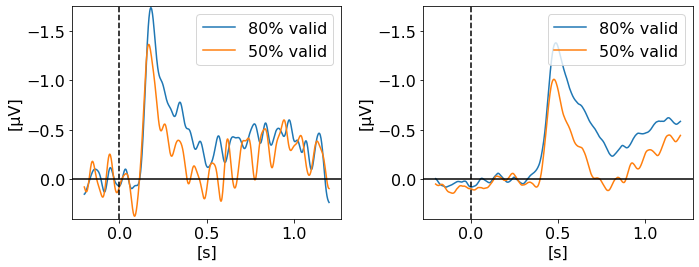

In [16]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(10,4))

# use only 1.2s epoch data, not 1.5s
nb_points = cda_all['80% valid'].shape[1]
times = times[:nb_points]
cda_all_matlab['5'] = cda_all_matlab['5'][:,:nb_points]
cda_all_matlab['6'] = cda_all_matlab['6'][:,:nb_points]

# 2. Plot Figure #1
axs[0].plot(times, cda_all['80% valid'].mean(0) * 1e6, label='80% valid')
axs[0].plot(times, cda_all['50% valid'].mean(0) * 1e6, label='50% valid')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')
axs[0].set_ylim([0.4, -1.75])

# 2. Plot Figure #2
cda_all_matlab['5'] = cda_all_matlab['5']
axs[1].plot(times, cda_all_matlab['5'].mean(0), label='80% valid')
axs[1].plot(times, cda_all_matlab['6'].mean(0), label='50% valid')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')
axs[1].set_ylim([0.4, -1.75])

plt.tight_layout()
fig.savefig("./Gunseli-2019_CDA-reprod-comp.png", dpi=300, format='png')

## Save CDA Data

In [4]:
data_pickle = dict()
data_pickle['times'] = times
data_pickle['CDA'] = cda_dict_all
data_pickle['epochs'] = epochs_dict_all
data_pickle['report'] = report
data_pickle['report_perf'] = perf_report_all

with open("{}_clean-20hz.pkl".format(study_id),"wb") as f:
    pickle.dump(data_pickle, f)

## Load CDA Data

In [4]:
with open("{}_clean-20hz.pkl".format(study_id),"rb") as f:
    data_pickle = pickle.load(f)
    
times = data_pickle['times']
cda_dict_all = data_pickle['CDA']
epochs_dict_all = data_pickle['epochs']
report = data_pickle['report']
perf_report_all = data_pickle['report_perf']

len(cda_dict_all)

30

## Analysis - Bad Perf Trials

==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp2.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp3.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp4.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp5.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp7.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp6.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp13.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp12.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp10.set - Cond: 80% valid)
Manual Skip...
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp15.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp29.set - Cond: 80% valid)
==== SKIPPED: 0 points! (File: StratAtt_e2_LoadChans_pp28.set - Cond: 80% valid)
==== SKIPPED: 0 poi

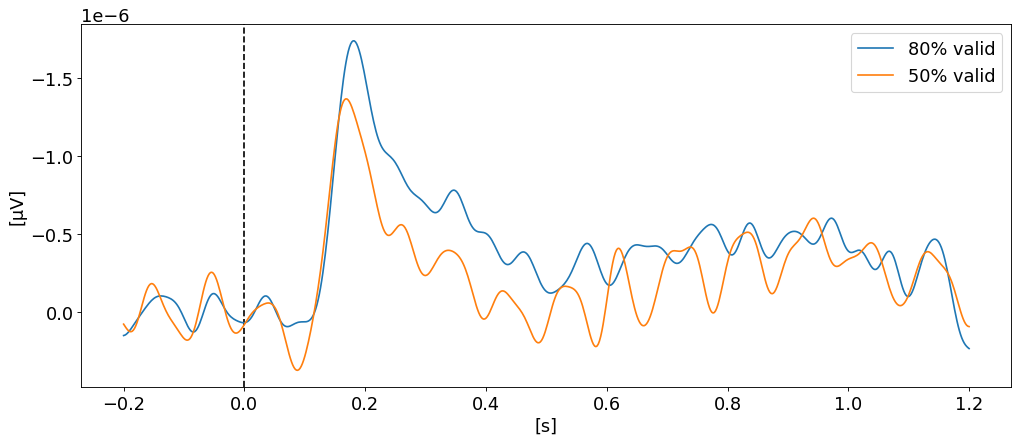

In [11]:
cda_all_bad = dict()

for cond in cda_dict_all[list(cda_dict_all.keys())[0]].keys():
    cda_all_bad[cond] = dict()

    for f in cda_dict_all.keys():
        ## ====== Manual Cleanup ========
        # TODO: Skip only 1 side.
        # TODO: Look at pp24 cue 6
        # TODO: Look at pp18 cue 5
        if (f == 'StratAtt_e2_LoadChans_pp11.set') or (f == 'StratAtt_e2_LoadChans_pp18.set' and cond == '5') or (f == 'StratAtt_e2_LoadChans_pp24.set' and cond == '6'):
        #if (f == 'StratAtt_e2_LoadChans_pp11.set'):# or (f == 'StratAtt_e2_LoadChans_pp18.set') or (f == 'StratAtt_e2_LoadChans_pp24.set'):
            print('Manual Skip...')
            continue
            
        perf = 'bad'
        
        ldict = cda_dict_all[f][cond]['left']
        rdict = cda_dict_all[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict_all[f][cond]['left'][perf] + cda_dict_all[f][cond]['right'][perf])/2
            if ~np.isnan(cda_dict_cur[0]):
                cda_all_bad[cond] = np.vstack([cda_all_bad[cond], cda_dict_cur]) if len(cda_all_bad[cond]) else cda_dict_cur
        elif (perf in ldict.keys() and len(ldict[perf])):
            cda_dict_cur = cda_dict_all[f][cond]['left'][perf]
            if ~np.isnan(cda_dict_cur[0]):
                cda_all_bad[cond] = np.vstack([cda_all_bad[cond], cda_dict_cur]) if len(cda_all_bad[cond]) else cda_dict_cur
        elif (perf in rdict.keys() and len(rdict[perf])):
            cda_dict_cur = cda_dict_all[f][cond]['right'][perf]
            if ~np.isnan(cda_dict_cur[0]):
                cda_all_bad[cond] = np.vstack([cda_all_bad[cond], cda_dict_cur]) if len(cda_all_bad[cond]) else cda_dict_cur            
        else:
            print("==== SKIPPED: 0 points! (File: {} - Cond: {})".format(str(f), str(cond)))

# Plot
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['80% valid'].mean(0), label='80% valid')
plt.plot(times, cda_all['50% valid'].mean(0), label='50% valid')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.gca().invert_yaxis()

#plt.savefig("./{}-bad.png".format(study_id), dpi=300, format='png')

## Analysis - Show Spread per subject

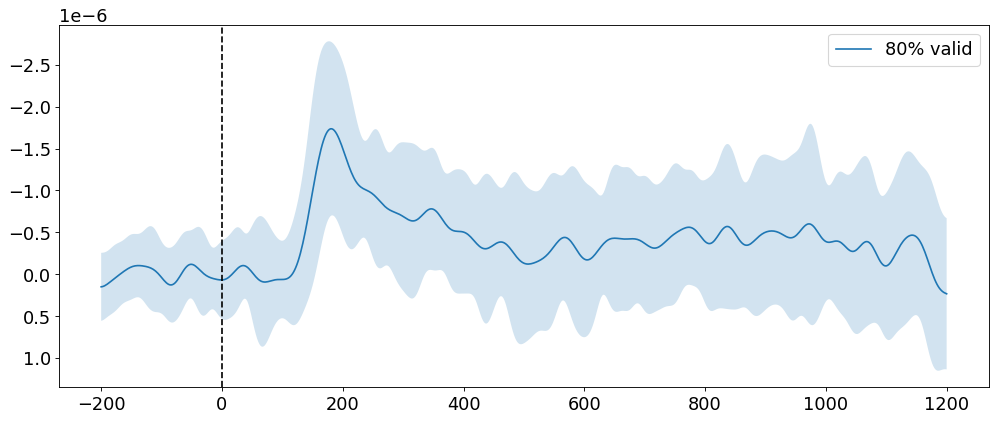

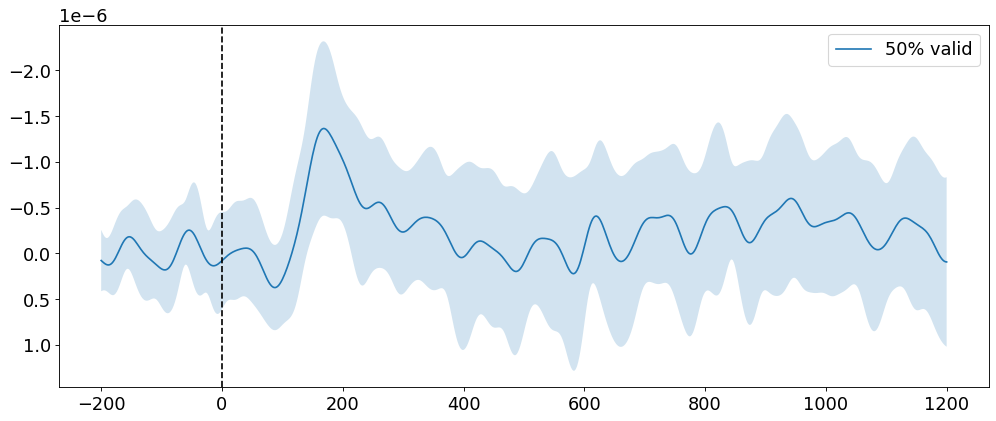

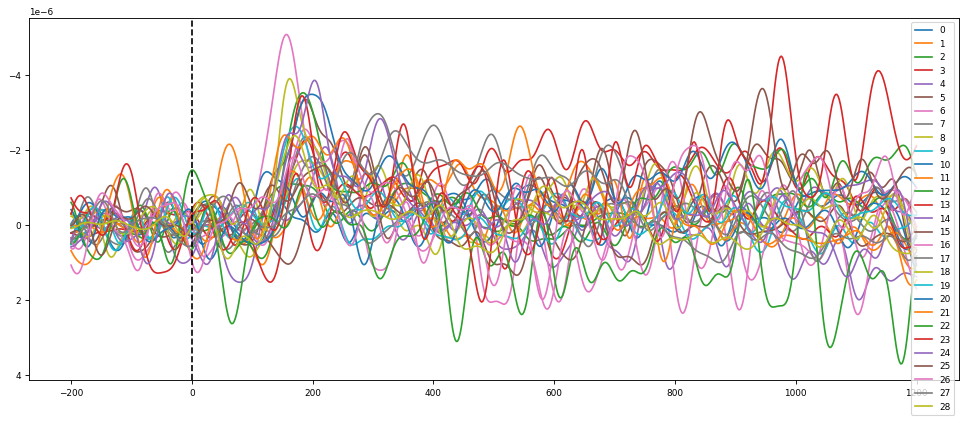

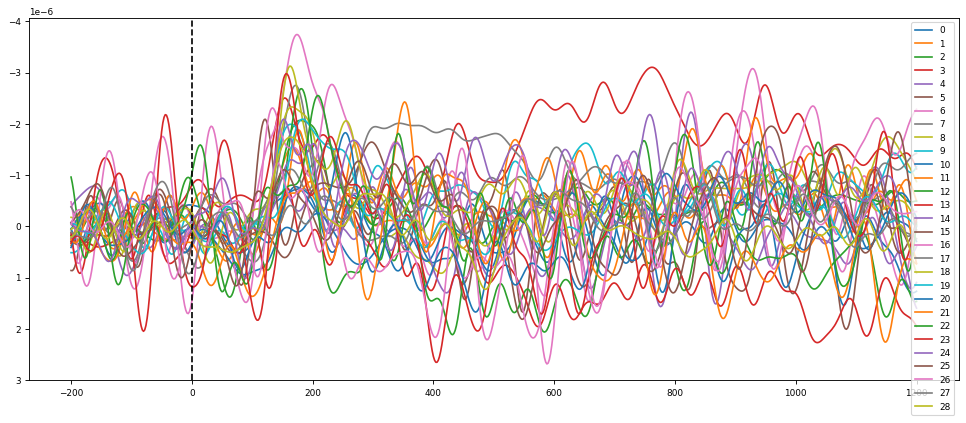

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_21297/2080971371.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, len(conds), figsize=(15,6))


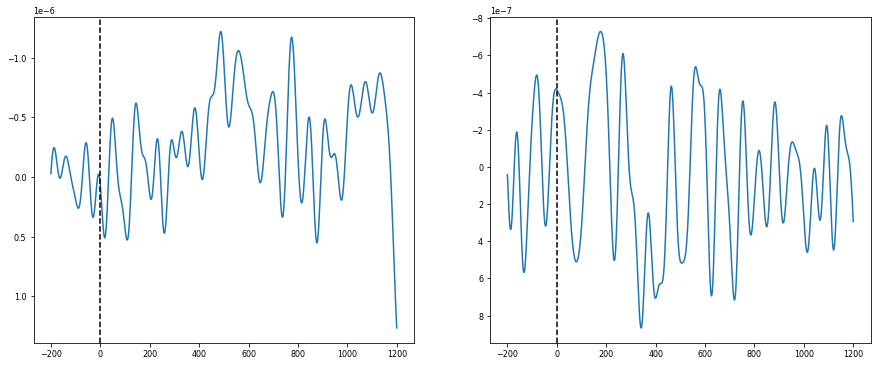

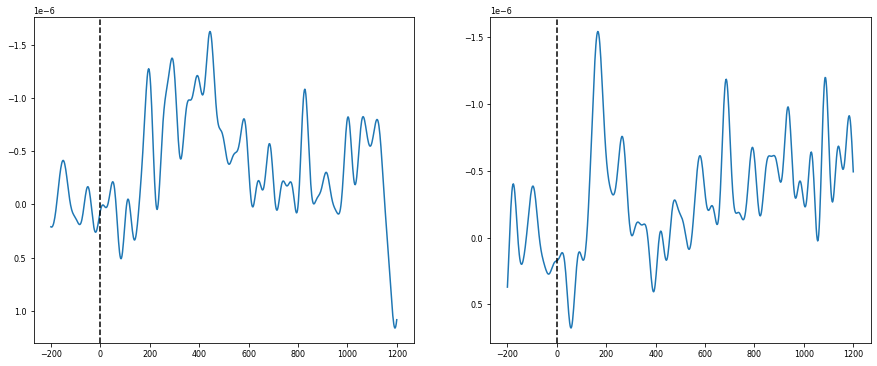

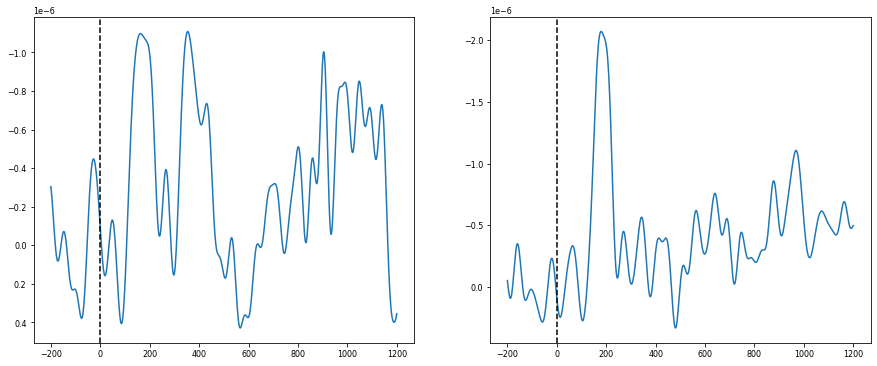

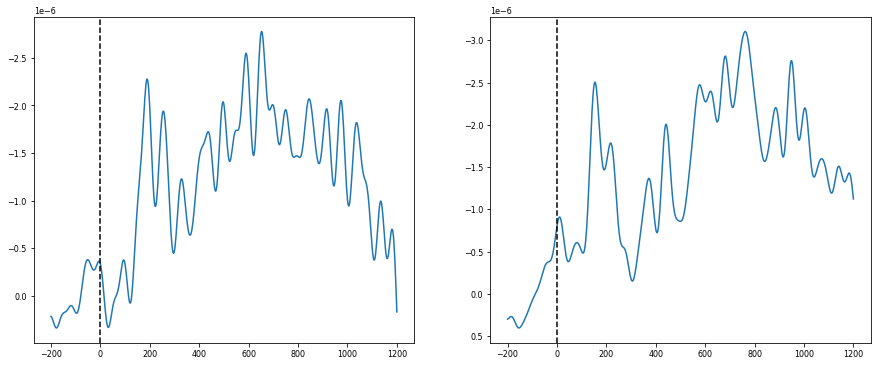

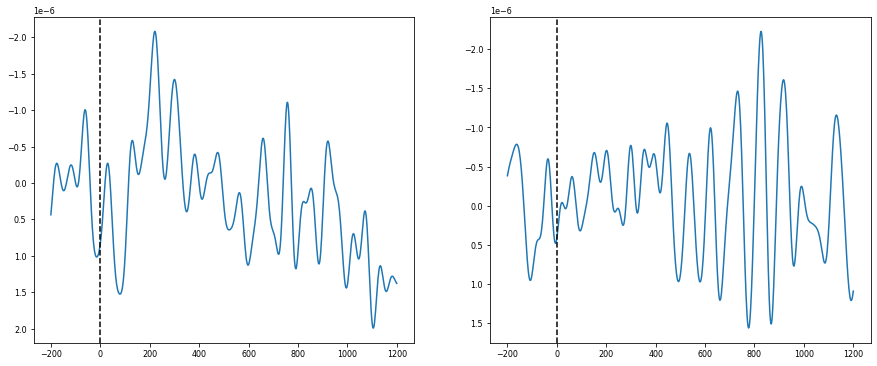

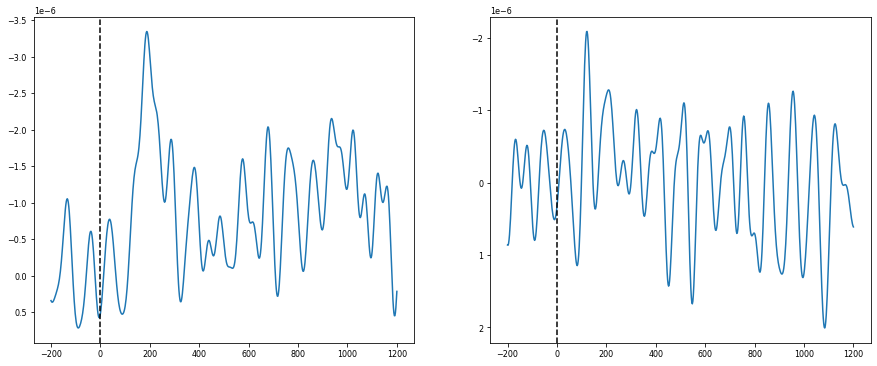

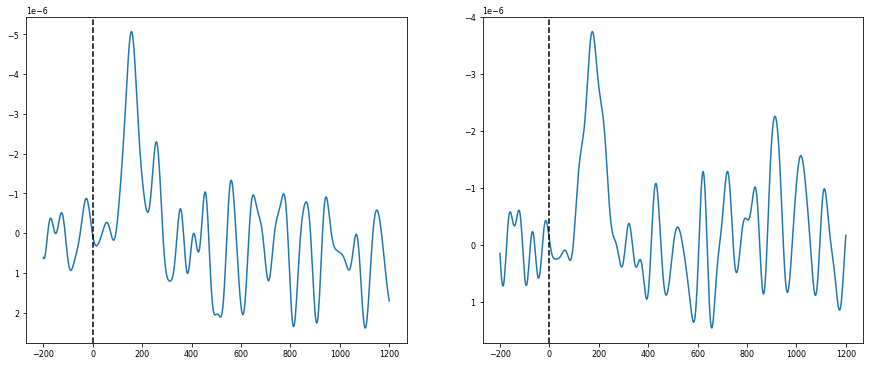

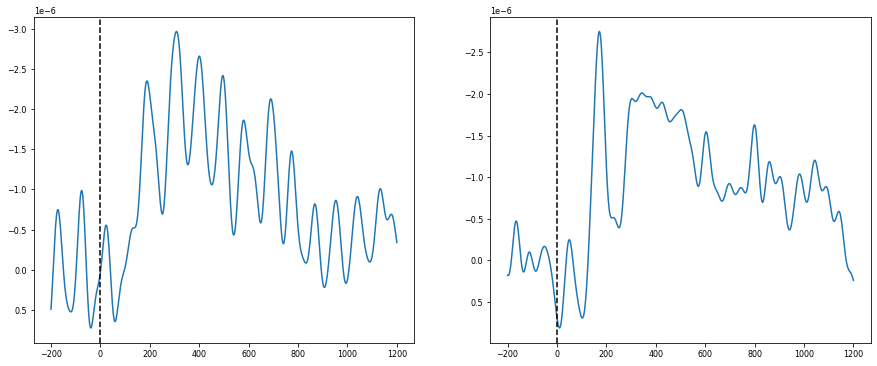

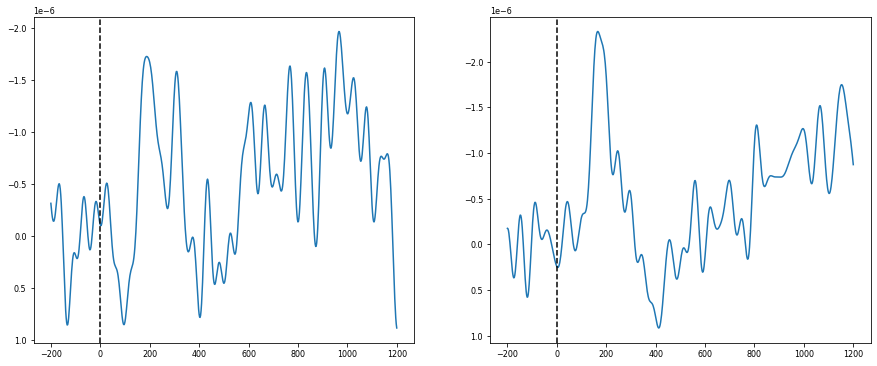

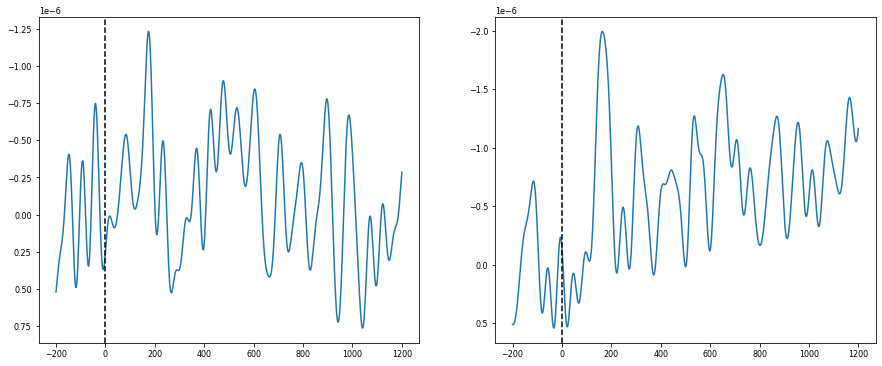

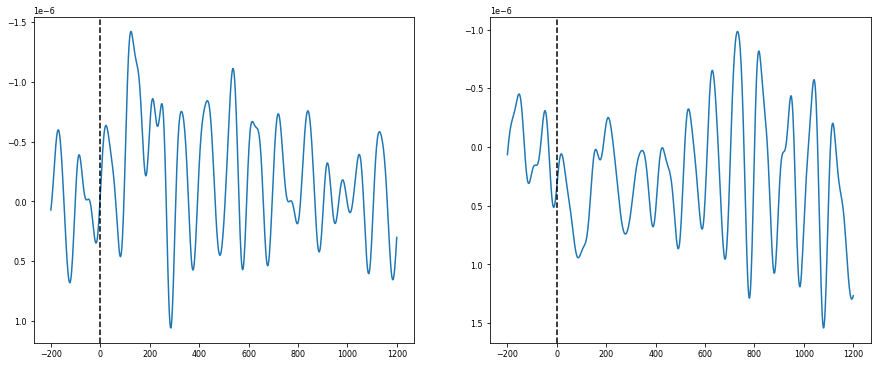

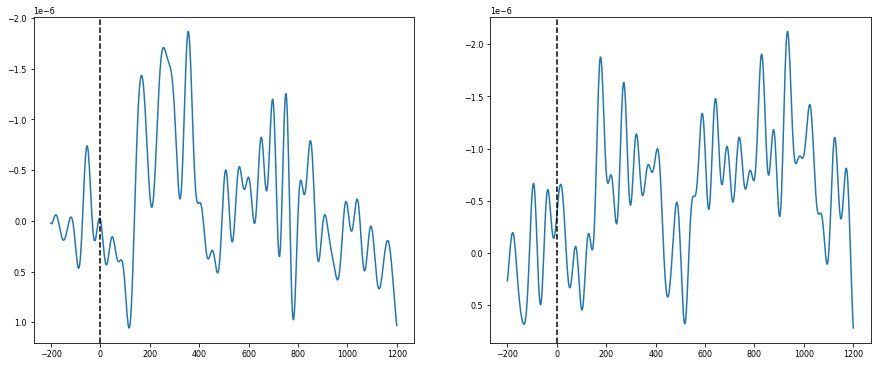

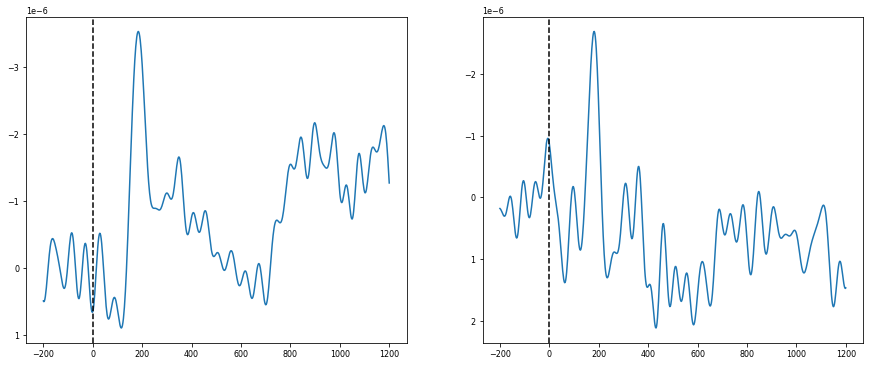

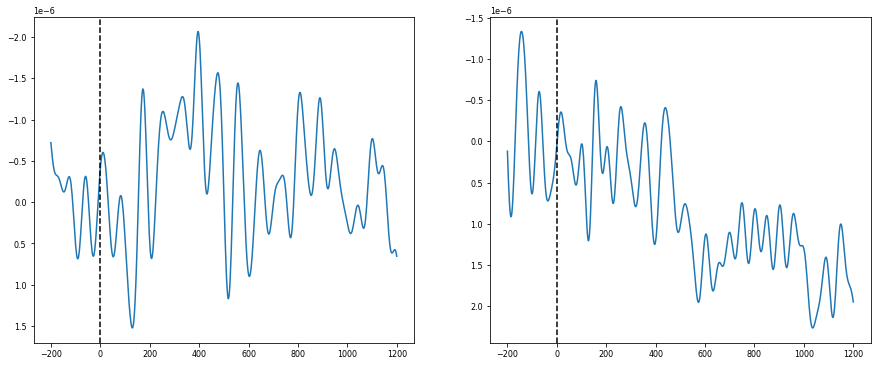

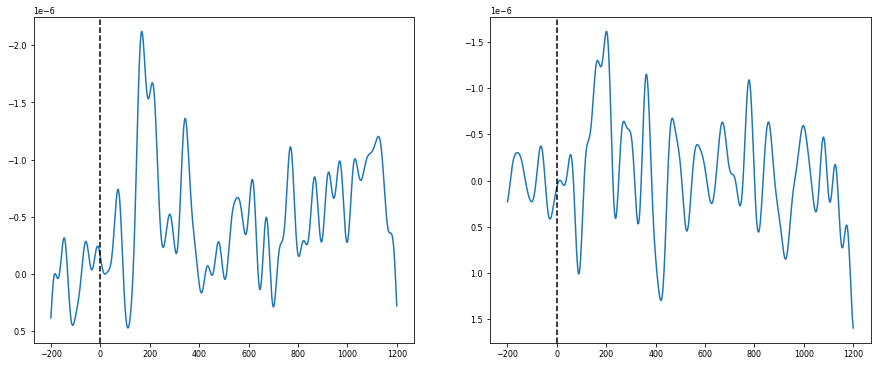

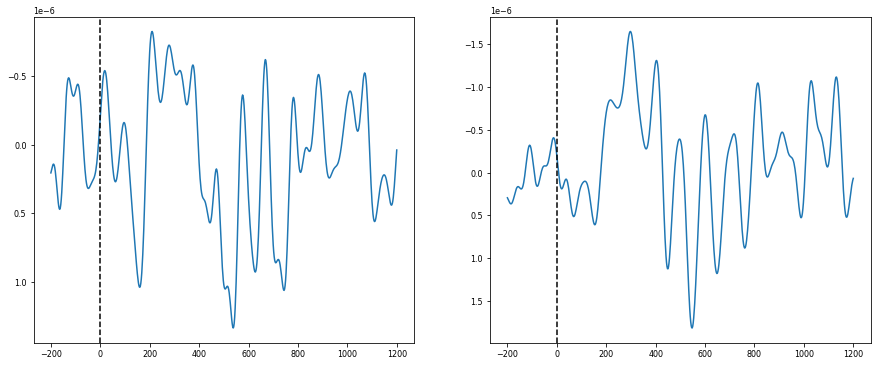

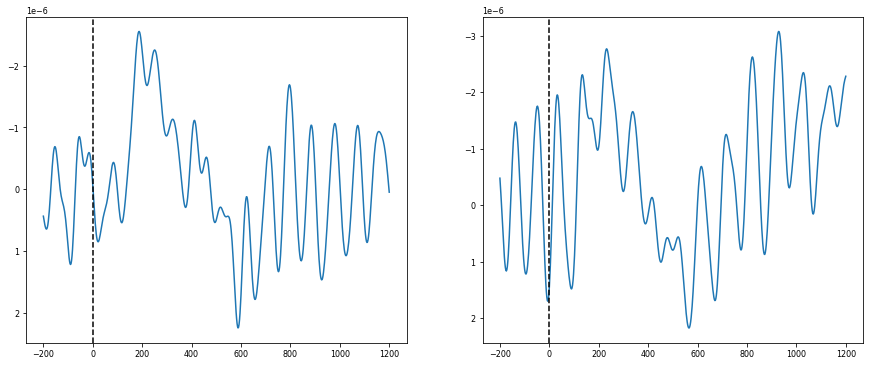

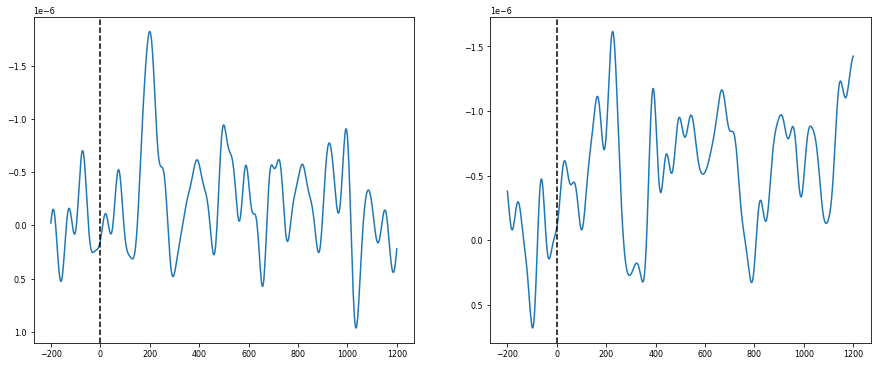

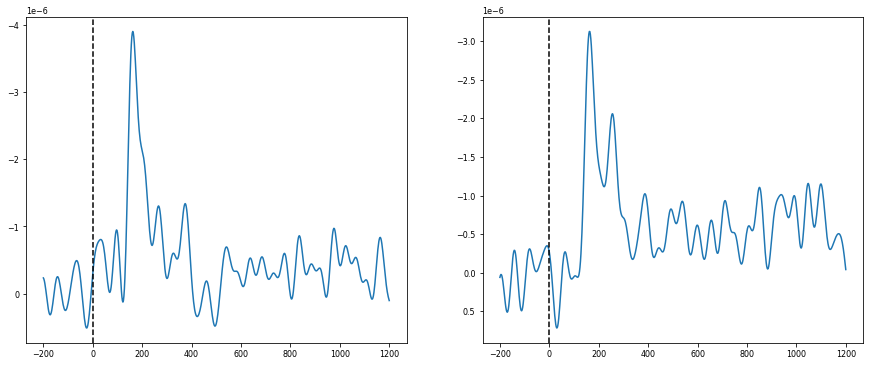

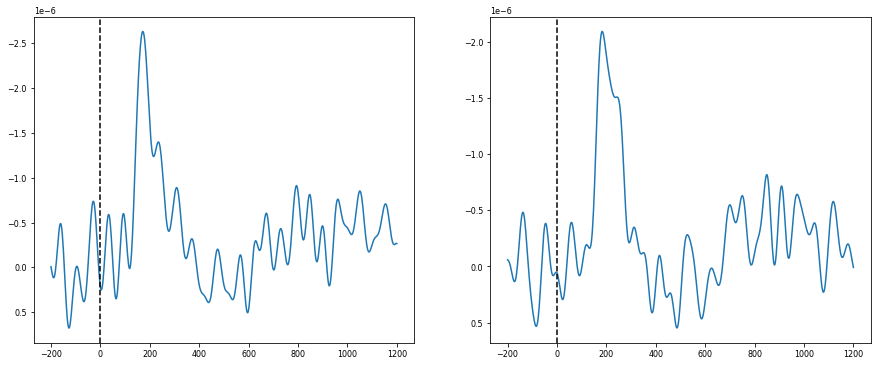

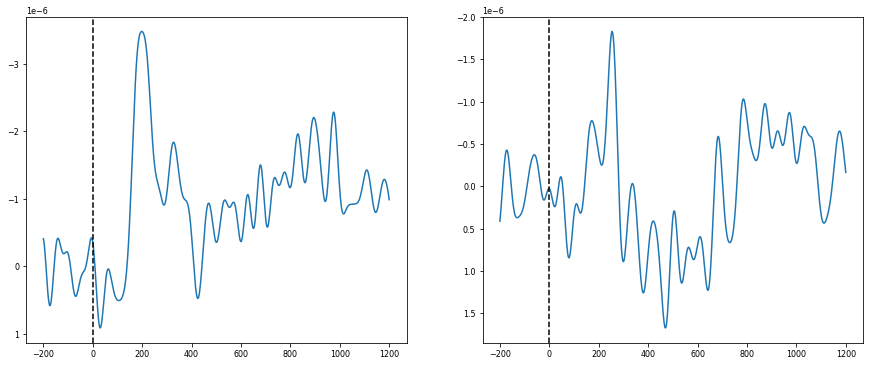

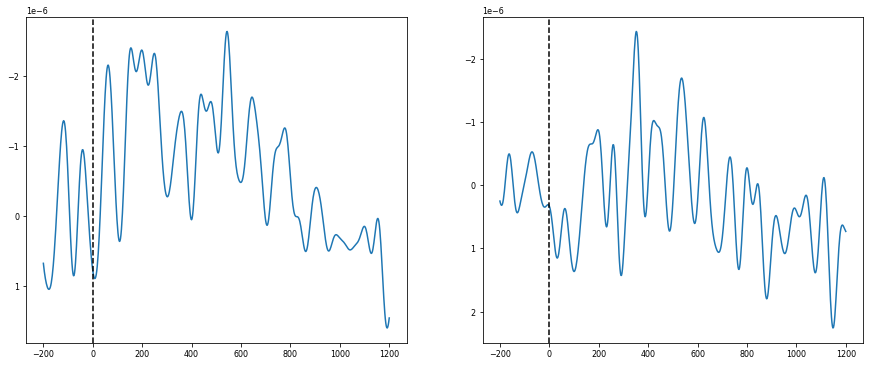

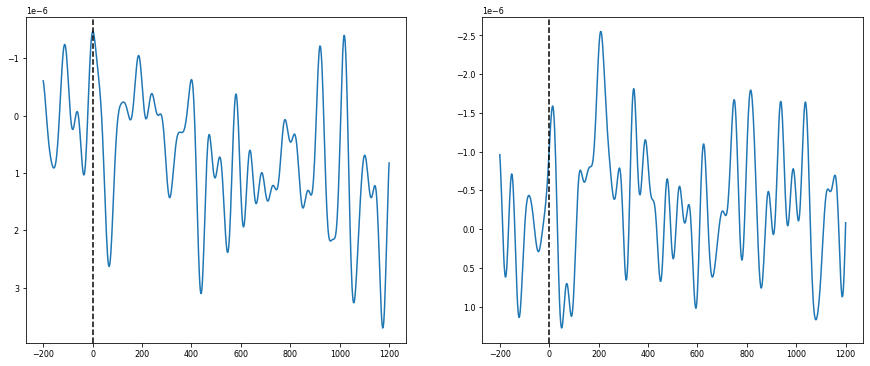

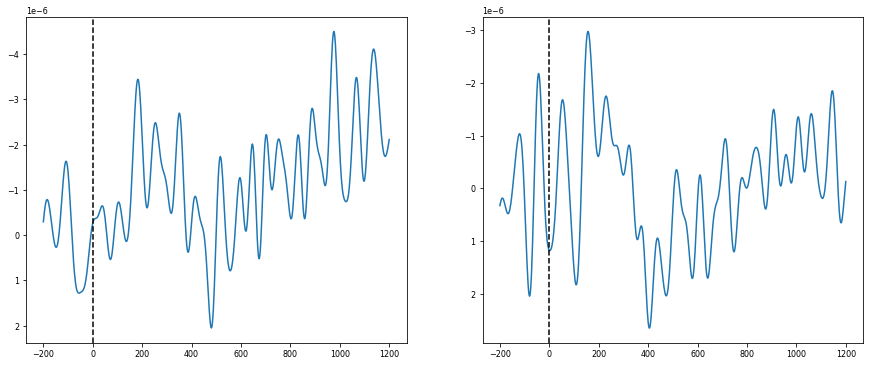

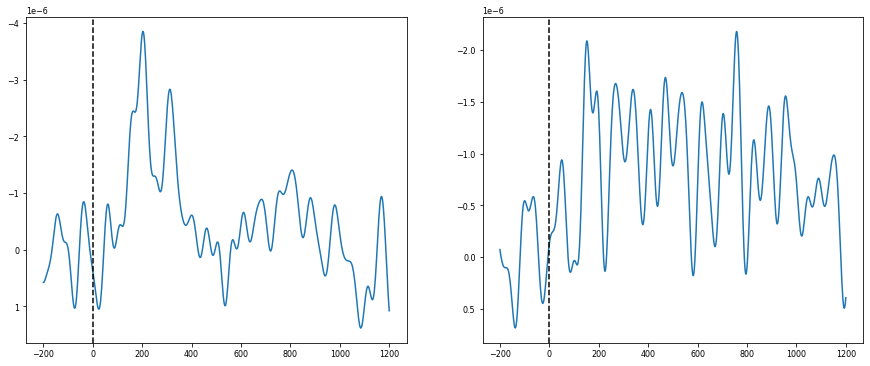

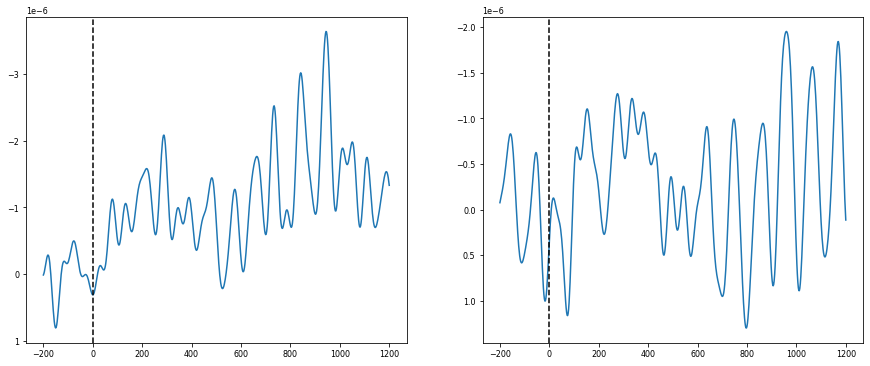

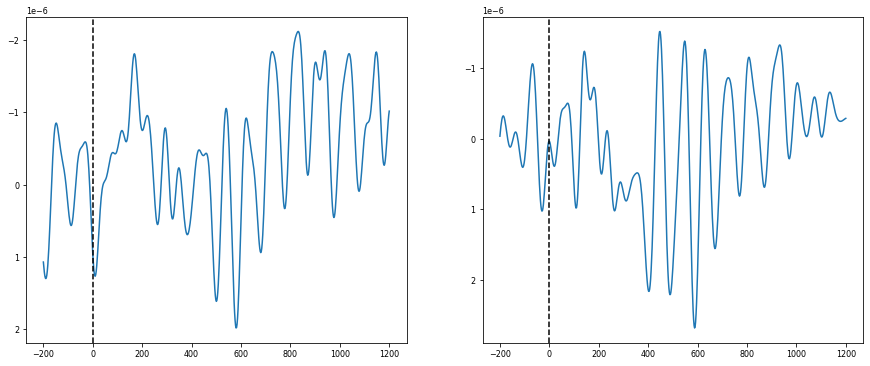

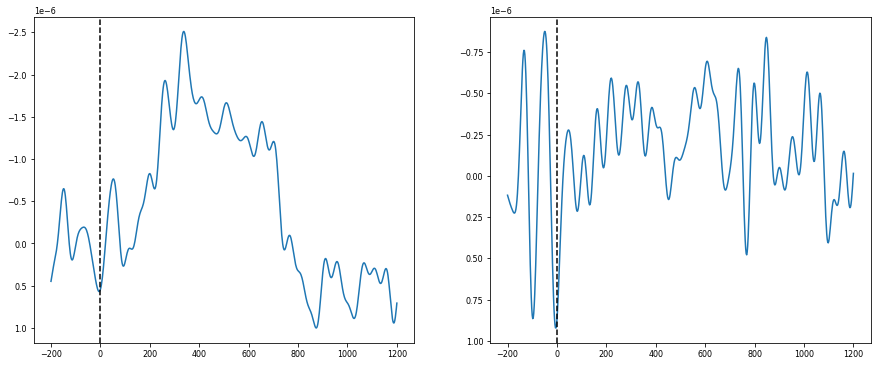

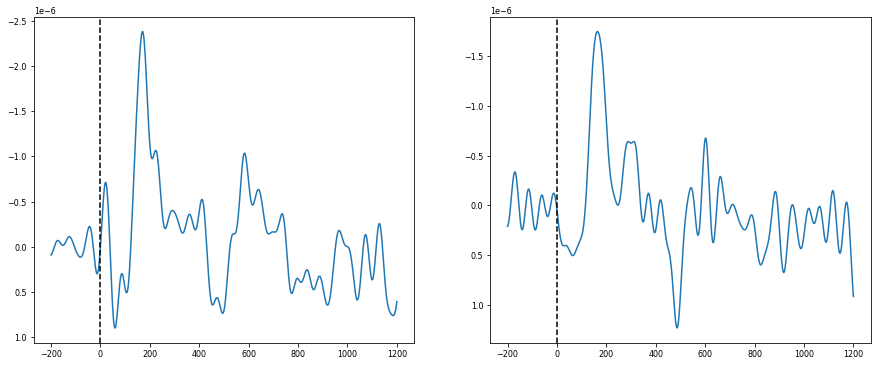

In [7]:
plt.rcParams.update({'font.size': 16})
for cond in conds:
    plt.figure(figsize=(15, 6), dpi=80)
    means = cda_all[cond].mean(0)
    stds = cda_all[cond].std(0)
    plt.plot((times * 1000), means, label=cond)
    plt.fill_between((times * 1000), means-stds,means+stds,alpha=.2)

    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

plt.rcParams.update({'font.size': 8})
for cond in conds:
    plt.figure(figsize=(15, 6), dpi=80)
    for i in range(len(cda_all[cond])):
        plt.plot((times * 1000), cda_all[cond][i,:], label='{}'.format(i))

    plt.axvline(x=0, color='k', linestyle='--')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

plt.rcParams.update({'font.size': 8})
#plt.figure(figsize=(15, 6), dpi=80)
for subject in range(len(cda_all[conds[0]])):
    fig, axs = plt.subplots(1, len(conds), figsize=(15,6))
    for i, cond in enumerate(conds):
        axs[i].plot((times * 1000), cda_all[cond][subject,:], label='{}'.format(i))
        axs[i].axvline(x=0, color='k', linestyle='--')
        axs[i].invert_yaxis()
    
#plt.gca().invert_yaxis()
#plt.legend()
plt.show()

## Analysis - Performance Report (CDA per Subject)

In [8]:
report = report.loc[:,~report.columns.duplicated()]

## Subjects: Perf (Good/Bad) vs CDA Amp

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_21297/3259733699.py:15: RuntimeWarning: Mean of empty slice
  axs[i].axhline(y=np.nanmean(y), color='red', linestyle='--')


Text(0, 0.5, 'Mean CDA Amplitude')

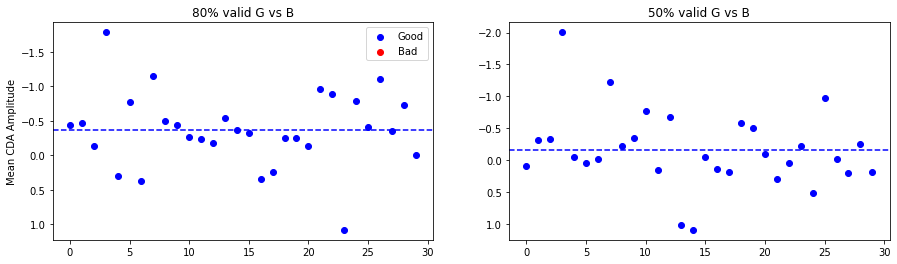

In [9]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, len(conds), figsize=(15,4))

for i, cond in enumerate(conds):
    x = range(len(report['{}-right-good-CDA'.format(cond)]))
    
    # Good
    y = (report['{}-right-good-CDA'.format(cond)] + report['{}-left-good-CDA'.format(cond)]) / 2
    axs[i].scatter(x=x, y=y, color='blue', label='Good')
    axs[i].axhline(y=np.nanmean(y), color='blue', linestyle='--')
    # Bad
    y = (report['{}-right-bad-CDA'.format(cond)] + report['{}-left-bad-CDA'.format(cond)]) / 2
    axs[i].scatter(x=x, y=y, color='red', label='Bad')
    axs[i].axhline(y=np.nanmean(y), color='red', linestyle='--')
    
    axs[i].set_title('{} G vs B'.format(cond))
    axs[i].invert_yaxis()
    
axs[0].legend()
axs[0].set_ylabel('Mean CDA Amplitude')
    

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_21297/767501148.py:9: RuntimeWarning: Mean of empty slice
  bads_mean = np.nanmean(bads)


ZeroDivisionError: division by zero

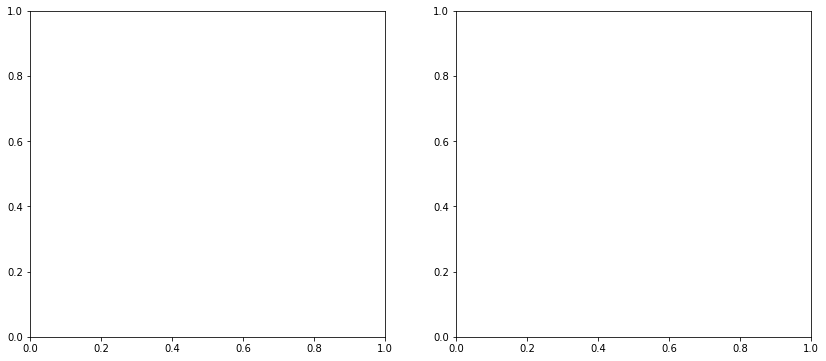

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Data
goods = np.array(report['good-CDA'])
bads = np.array(report['bad-CDA'])

# Calculate the average
goods_mean = np.nanmean(goods)
bads_mean = np.nanmean(bads)

# Calculate the standard deviation
goods_std = np.nanstd(goods)
bads_std = np.nanstd(bads)

# Define labels, positions, bar heights and error bar heights
labels = ['Good', 'Bad']
x_pos = np.arange(len(labels))
CTEs = [goods_mean, bads_mean]
error = [goods_std, bads_std]

# Build the plot
axs[0].bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
axs[0].set_ylabel('Mean Amp')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(labels)
axs[0].set_title('Mean Amp vs # Perf')
axs[0].invert_yaxis()
#ax.yaxis.grid(True)

x = range(len(report['good-CDA']))
axs[1].scatter(x=x, y=report['good-CDA'], color='blue')
axs[1].scatter(x=x, y=report['bad-CDA'], color='red')

#plt.tight_layout()
plt.show()

import scipy
x = []
y = []
for p in perfs:
    for value in report['{}-CDA'.format(p)]:
        if p == 'good':
            x.append(1)
        else:
            x.append(2)
        y.append(value)

print('Corr Perf vs CDA Amp: {}'.format(scipy.stats.pearsonr(x,y)))

## Subjects: Condition vs CDA Amp

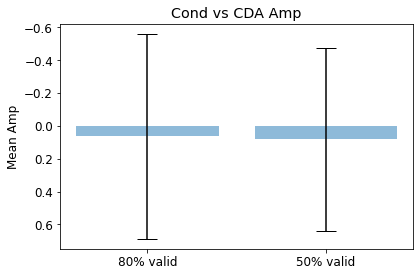

In [12]:
plt.rcParams.update({'font.size': 12})

data_conds = dict()
for cond in conds:
    data_conds[cond] = dict()
    data_conds[cond]['data'] = np.array(report['{}-good-CDA'.format(cond)])
    data_conds[cond]['mean'] = np.nanmean(data_conds[cond]['data'])
    data_conds[cond]['std'] = np.nanstd(data_conds[cond]['data'])
    
labels = conds
x_pos = np.arange(len(labels))
CTEs = [data_conds[cond]['mean'] for cond in conds]
error = [data_conds[cond]['std'] for cond in conds]

fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Amp')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Cond vs CDA Amp')
ax.invert_yaxis()
#ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Pearson's Correlation
import scipy
x = []
y = []
set_sizes = conds
for i, ss in enumerate(set_sizes):
    for value in report['{}-good-CDA'.format(ss)]:
        x.append(i)
        y.append(value)

print('Corr Cond vs CDA Amp: {}'.format(scipy.stats.pearsonr(x,y)))

Corr Cond vs CDA Amp: (0.01567891053118042, 0.9053539549780238)


## Subjects: Side (Left/Right) vs CDA Amp

Corr Side vs CDA Amp: (0.48176824967755355, 1.5285504223337644e-06)


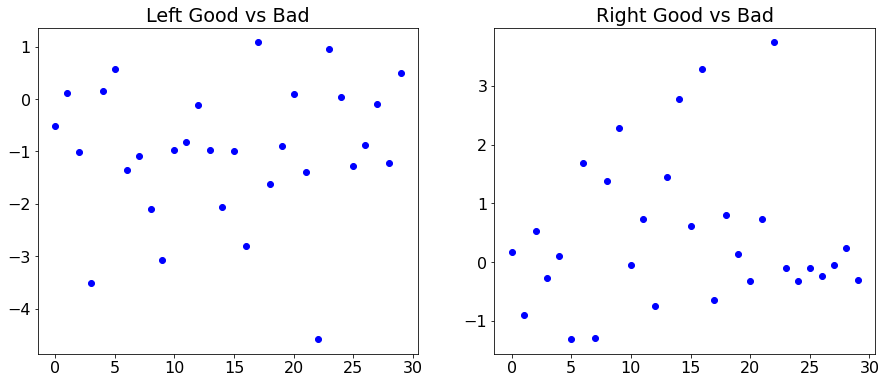

In [14]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(15,6))

x = range(len(report['left-good-CDA']))
axs[0].scatter(x=x, y=report['left-good-CDA'], color='blue')
x = range(len(report['left-bad-CDA']))
axs[0].scatter(x=x, y=report['left-bad-CDA'], color='red')
axs[0].set_title('Left Good vs Bad')

x = range(len(report['right-good-CDA']))
axs[1].scatter(x=x, y=report['right-good-CDA'], color='blue')
x = range(len(report['right-bad-CDA']))
axs[1].scatter(x=x, y=report['right-bad-CDA'], color='red')
axs[1].set_title('Right Good vs Bad')

x = []
y = []
for i, side in enumerate(sides):
    for value in report['{}-good-CDA'.format(side)]:
        x.append(i)
        y.append(value)

print('Corr Side vs CDA Amp: {}'.format(scipy.stats.pearsonr(x,y)))

## Subjects: Accuracy / Performance vs CDA Amp

Corr Perf Acc ~ 80% valid: (nan, nan)
Corr Perf Acc ~ 50% valid: (nan, nan)


/Users/nick/opt/miniconda3/envs/clct/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0, 0.5, 'CDA Mean Amp')

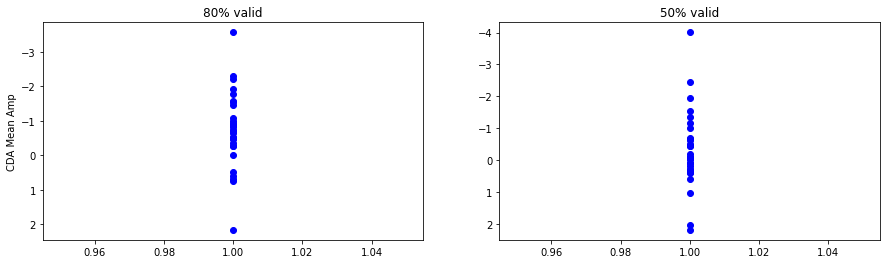

In [15]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, len(conds), figsize=(15,4))

for i, cond in enumerate(conds):
    goods = (report['{}-left-good'.format(cond)] + report['{}-right-good'.format(cond)])/2
    bads = (report['{}-left-bad'.format(cond)] + report['{}-right-bad'.format(cond)])/2
    x = goods / (goods + bads)
    y = report['{}-left-good-CDA'.format(cond)] + report['{}-right-good-CDA'.format(cond)]
    axs[i].scatter(x=x, y=y, color='blue')
    axs[i].invert_yaxis()
    axs[i].set_title('{}'.format(cond))
    
    print('Corr Perf Acc ~ {}: {}'.format(cond, scipy.stats.pearsonr(x,y)))

axs[0].set_ylabel('CDA Mean Amp')

## Trials: Conditions vs Amp

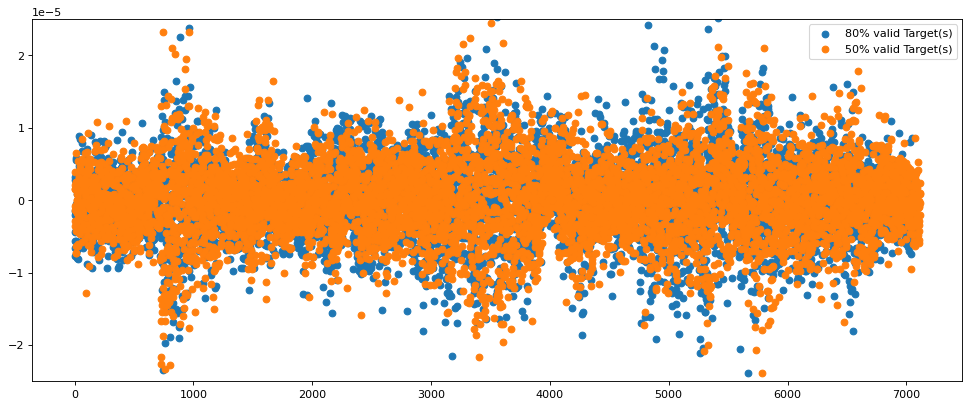

In [16]:
plt.figure(figsize=(15, 6), dpi=80)

for i, cond in enumerate(conds):
    y1 = []
    for f in perf_report_all.keys():
        for side in sides:
            for value in perf_report_all[f][cond][side]['good']:
                y1.append(value)
    x1 = range(len(y1))

    plt.scatter(x=x1, y=y1, label='{} Target(s)'.format(cond))

plt.ylim(-2.5*1e-5,2.5*1e-5)
plt.legend()
plt.show()

## Trials: Good vs Bad

Cond = 80% valid Targets: 4680 Good Perf Trials vs 0 Bad Perf Trials, with 0 outliers on graph.
Cond = 50% valid Targets: 4695 Good Perf Trials vs 0 Bad Perf Trials, with 3 outliers on graph.


Text(0, 0.5, 'CDA mean amplitude')

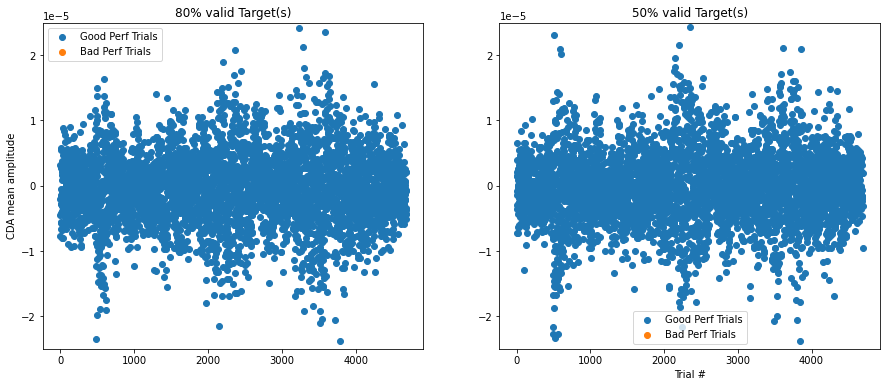

In [17]:
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(1, len(conds), figsize=(15,6))

for i, cond in enumerate(conds):
    y1 = []
    for f in perf_report_all.keys():
        for value in perf_report_all[f][cond]['left']['good']:
            y1.append(value)
        for value in perf_report_all[f][cond]['right']['good']:
            y1.append(value)
    x1 = range(len(y1))

    y2 = []
    for f in perf_report_all.keys():
        if 'bad' in perf_report_all[f][cond]['left'].keys():
            for value in perf_report_all[f][cond]['left']['bad']:
                y2.append(value)
        if 'bad' in perf_report_all[f][cond]['right'].keys():
            for value in perf_report_all[f][cond]['right']['bad']:
                y2.append(value)
    x2 = range(len(y2))

    axs[i].scatter(x=x1, y=y1, label='Good Perf Trials')
    axs[i].scatter(x=x2, y=y2, label='Bad Perf Trials')
    axs[i].legend()
    axs[i].set_ylim(-2.5*1e-5,2.5*1e-5)
    axs[i].set_title('{} Target(s)'.format(cond))

    nb_outliers = len([val for val in (y1 + y2) if ((val*1e5) > 2.5) or ((val*1e5) < -2.5)])
    print('Cond = {} Targets: {} Good Perf Trials vs {} Bad Perf Trials, with {} outliers on graph.'.format(cond, len(y1), len(y2), nb_outliers))

axs[1].set_xlabel('Trial #')
axs[0].set_ylabel('CDA mean amplitude')
#fig.tight_layout(pad=1.0)

## Trials: Left vs Right

Cond = 80% valid Targets: 2360 Good Left Trials vs 2320 Good Right Trials, with 0 outliers on graph
Cond = 50% valid Targets: 2354 Good Left Trials vs 2341 Good Right Trials, with 3 outliers on graph


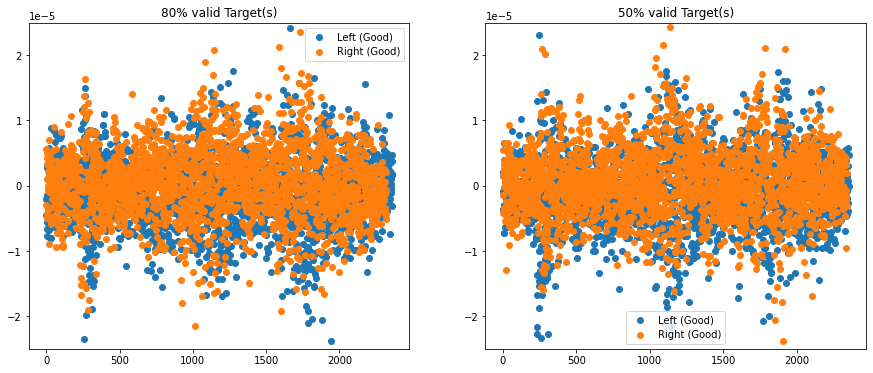

In [18]:
fig, axs = plt.subplots(1, len(conds), figsize=(15,6))

for i, cond in enumerate(conds):
    y1 = []
    for f in perf_report_all.keys():
        for value in perf_report_all[f][cond]['left']['good']:
            y1.append(value)
    x1 = range(len(y1))

    y2 = []
    for f in perf_report_all.keys():
        for value in perf_report_all[f][cond]['right']['good']:
            y2.append(value)
    x2 = range(len(y2))

    axs[i].scatter(x=x1, y=y1, label='Left (Good)')
    axs[i].scatter(x=x2, y=y2, label='Right (Good)')
    axs[i].legend()
    axs[i].set_title('{} Target(s)'.format(cond))
    axs[i].set_ylim(-2.5*1e-5,2.5*1e-5)

    nb_outliers = len([val for val in (y1 + y2) if ((val*1e5) > 2.5) or ((val*1e5) < -2.5)])
    print('Cond = {} Targets: {} Good Left Trials vs {} Good Right Trials, with {} outliers on graph'.format(cond, len(y1), len(y2), nb_outliers))
        